# Introduccion

El objetivo de este proyecto es analizar el comportamiento de los usuarios de la aplicacion "Trash to Treasure" mediante la segmentacion basada en metricas clave, como la tasa de retencion y la frecuencia de eventos. A traves de un analisis exploratorio de datos y pruebas de hipotesis, buscaremos identificar patrones que permitan optimizar la experiencia del usuario y mejorar el rendimiento de la aplicacion. Este enfoque nos ayudara a comprender mejor las necesidades de nuestros usuarios y a fomentar un uso mas efectivo de la plataforma.

# Procesamiento de datos

## Carga de datasets e importacion de librerias

In [135]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
from datetime import datetime
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import TTestIndPower

In [136]:
mobile= pd.read_csv('mobile_dataset_us.csv')
sources= pd.read_csv('mobile_sources_us.csv')

In [137]:
mobile.head(5)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [138]:
sources.head(5)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,bing
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,bing
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


## Estudio de datos

### Dataset Mobile

In [139]:
mobile.describe()

,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


In [140]:
mobile.isna().sum()

event.time    0
event.name    0
user.id       0
dtype: int64

In [141]:
mobile.duplicated().sum()

0

In [142]:
mobile.dtypes

event.time    object
event.name    object
user.id       object
dtype: object

In [143]:
mobile['event.time'] = pd.to_datetime(mobile['event.time'],utc=True) 
mobile['event.time'] = mobile['event.time'].dt.tz_localize(None)
mobile.dtypes

event.time    datetime64[ns]
event.name            object
user.id               object
dtype: object

Nota:
- Se cambiaron los datos de las fechas para que estas tengan el tipo de dato requerido con el metodo to_datetime, eliminando la zona horaria ya que requerimos tener solamente la fecha de la interacion. 

### Dataset sources

In [144]:
sources.describe()

,userId,source
count,4293,4293
unique,4293,3
top,020292ab-89bc-4156-9acf-68bc2783f894,bing
freq,1,1934


In [145]:
sources.isna().sum()

userId    0
source    0
dtype: int64

In [146]:
sources.duplicated().sum()

0

In [147]:
sources.dtypes

userId    object
source    object
dtype: object

# Analisis exploratorio de datos

## Tasa de retencion

In [148]:
first_use = mobile.groupby('user.id')['event.time'].min().reset_index()
first_use.rename(columns={'event.time': 'first_event_time'}, inplace=True)
merged_data = pd.merge(mobile, first_use, on='user.id')
retained_users = merged_data[merged_data['event.time'] > merged_data['first_event_time']]
retention_rate = retained_users['user.id'].nunique() / first_use['user.id'].nunique()
print("Tasa de retencion:", retention_rate)

Tasa de retencion: 0.9848590729093873


## Tiempo en la aplicacion

In [149]:
mobile['event.time'] = pd.to_datetime(mobile['event.time'])
time_spent = mobile.groupby('user.id').agg({'event.time': 'count'}).rename(columns={'event.time': 'time_spent'})
time_spent

,time_spent
user.id,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
00157779-810c-4498-9e05-a1e9e3cedf93,71
00463033-5717-4bf1-91b4-09183923b9df,10
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
00551e79-152e-4441-9cf7-565d7eb04090,8
...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
ffc01466-fdb1-4460-ae94-e800f52eb136,7
ffcf50d9-293c-4254-8243-4890b030b238,2


## Frecuencia de eventos

In [150]:
event_frequency = mobile.groupby('user.id').size().reset_index(name='event_count')
event_frequency

,user.id,event_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7
4290,ffcf50d9-293c-4254-8243-4890b030b238,2
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13


## Clustering

In [151]:
user_metrics = pd.merge(first_use, time_spent, on='user.id')
user_metrics = pd.merge(user_metrics, event_frequency, on='user.id')


In [152]:
scaler = StandardScaler()
user_metrics_scaled = scaler.fit_transform(user_metrics[['time_spent', 'event_count']])

In [153]:
kmeans = KMeans(n_clusters=3)
user_metrics['cluster'] = kmeans.fit_predict(user_metrics_scaled)
user_metrics

c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,user.id,first_event_time,time_spent,event_count,cluster
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,35,35,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,71,71,1
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,10,10,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,32,32,0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,8,8,0
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,17,17,0
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,7,7,0
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,2,2,0
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,13,13,0


## Analisis de grupos resultantes

In [154]:
numeric_columns = user_metrics.select_dtypes(include=['number']).columns
cluster_summary = user_metrics.groupby('cluster')[numeric_columns].mean()
user_metrics[numeric_columns] = user_metrics[numeric_columns].fillna(0) 
cluster_summary = user_metrics.groupby('cluster')[numeric_columns].mean()
print(cluster_summary)

         time_spent  event_count  cluster
cluster                                  
0         11.698705    11.698705      0.0
1         83.261538    83.261538      1.0
2        327.470588   327.470588      2.0


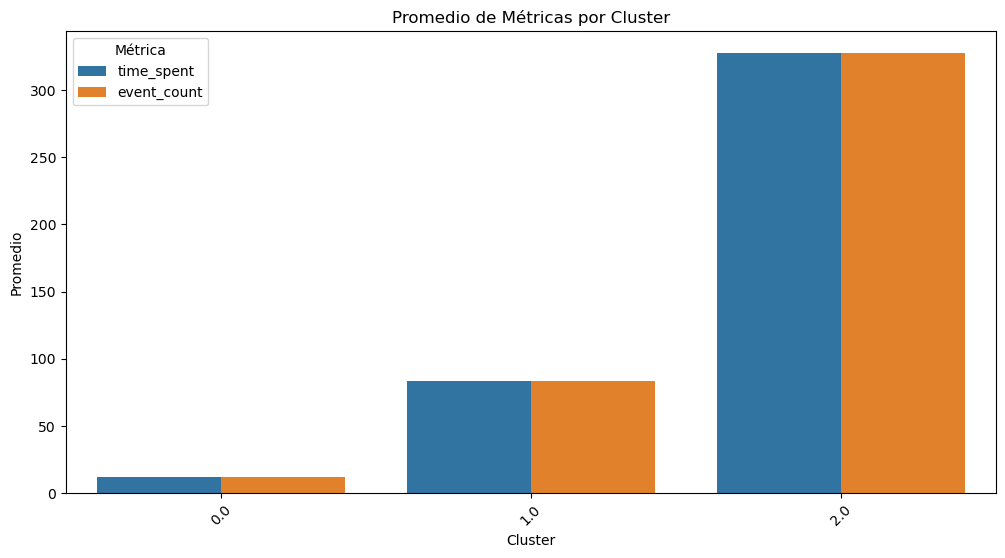

In [155]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_summary.melt(id_vars='cluster'), x='cluster', y='value', hue='variable')
plt.title('Promedio de Métricas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Promedio')
plt.legend(title='Métrica')
plt.xticks(rotation=45)
plt.show()

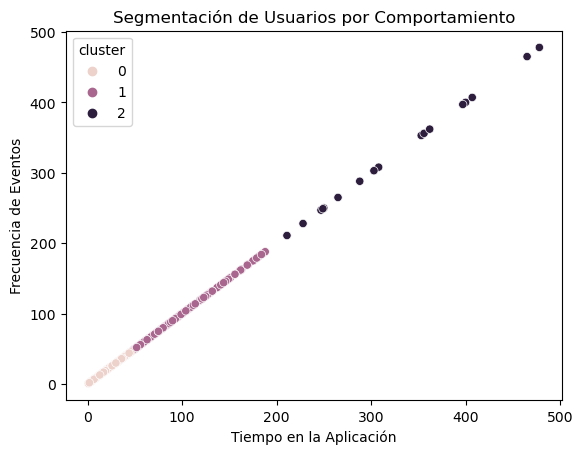

In [156]:
sns.scatterplot(data=user_metrics, x='time_spent', y='event_count', hue='cluster')
plt.title('Segmentación de Usuarios por Comportamiento')
plt.xlabel('Tiempo en la Aplicación')
plt.ylabel('Frecuencia de Eventos')
plt.show()

# Pruebas de Hipotesis

Hipotesis Nula: No hay diferencia en el número promedio de eventos realizados por los usuarios de Bing y Google.

In [157]:
merged_data = pd.merge(mobile, sources, left_on='user.id', right_on='userId')
event_counts = merged_data.groupby(['source', 'user.id']).size().reset_index(name='event_count')
average_events = event_counts.groupby('source')['event_count'].mean()
average_events


source
bing      17.728025
google    18.108946
other     15.826016
Name: event_count, dtype: float64

In [158]:
bing_events = event_counts[event_counts['source'] == 'bing']['event_count']
google_events = event_counts[event_counts['source'] == 'google']['event_count']

t_stat, p_value = ttest_ind(bing_events, google_events)
alpha = 0.05 

print(f"Estadística T: {t_stat}, P-valor: {p_value}")

if p_value < alpha:
    print("Rechazamos la hipotesis nula. Hay una diferencia significativa en el número de eventos.")
else:
    print("No se puede rechazar la hipotesis nula. No hay diferencia significativa en el numero de eventos.")

Estadística T: -0.32493677790509534, P-valor: 0.7452511266862527
No se puede rechazar la hipotesis nula. No hay diferencia significativa en el numero de eventos.


# Conlusiones:

- Interacción de Usuarios: Los usuarios en el segundo cluster destacan por tener la mayor interacción con la aplicación, lo que sugiere que están más comprometidos con su uso y podrían beneficiarse de estrategias específicas para aumentar aún más su participación.

- Relación entre Tiempo y Frecuencia: Se observa una correlación positiva entre el tiempo que cada usuario pasa en la aplicación y la frecuencia de sus visitas, indicando que los usuarios que utilizan la aplicación más a menudo tienden a invertir más tiempo en ella.

- Tasa de Retención: La aplicación presenta una impresionante tasa de retención del 98%, lo que demuestra su capacidad para mantener a los usuarios comprometidos y sugiere que la experiencia del usuario es altamente satisfactoria.

- Análisis de Hipótesis: Tras analizar la hipótesis, se concluye que no existen diferencias significativas en el comportamiento de los usuarios que descargaron la aplicación desde Google en comparación con aquellos que lo hicieron desde Bing. Esto indica que, independientemente de la fuente de descarga, la interacción y el uso de la aplicación son similares.